In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import ast


In [2]:
# Load data
edge_list = pd.read_csv('../02_data/train_test/edge_list.csv')
train_data = pd.read_csv('../02_data/train_test/train_data.csv')
test_data = pd.read_csv('../02_data/train_test/test_data.csv')

In [3]:
train_data

,domain,article_embedding,virality,year,domain_index,label
0,100giornidaleoni.it,[-3.62667615e-02 7.58439199e-02 -2.61213667e-...,0.947491,2021.904110,1420,0
1,100milefreepress.net,[ 0.08478758 -0.10553251 -0.04569786 -0.162647...,0.707107,2022.000000,3697,1
2,100percentfedup.com,[-0.00871386 0.01925436 -0.04681226 -0.048136...,0.697384,2022.440201,2636,0
3,1011now.com,[-2.87912979e-02 5.65173118e-02 -4.86887201e-...,0.833521,2021.611765,5049,1
4,10news.com,[ 5.50025127e-02 8.52471845e-03 -3.31000386e-...,0.871661,2021.804545,1292,1
...,...,...,...,...,...,...
4884,zmescience.com,[-3.80244223e-02 5.53963154e-02 6.77183802e-...,0.836262,2021.599291,5873,1
4885,zombie.news,[ 0.01009611 0.03097114 -0.12901936 -0.034202...,1.000000,2023.000000,153,0
4886,zonazealots.com,[ 0.03894909 -0.11853513 -0.31919676 -0.145071...,0.707107,2021.000000,978,1
4887,zuerst.de,[-7.06026978e-02 2.07726051e-01 -6.87203143e-...,0.987322,2022.823770,1032,1


In [4]:

# Ensure edge_list indices are within bounds
max_node_index = len(train_data) - 1
edge_list = edge_list[(edge_list['chat_id'] <= max_node_index) & (edge_list['domain_index'] <= max_node_index)]

# Split train_data into train and validation sets
train_domains, val_domains = train_test_split(train_data['domain_index'], test_size=0.2, random_state=42)


In [5]:
import numpy as np
import re

def preprocess_embedding(emb):
    """
    Preprocess and clean embedding values. Handles cases where:
    - The embedding is a string (requires cleaning and parsing).
    - The embedding is already a numpy array (no further processing needed).

    Args:
        emb: Embedding data (string or numpy array).

    Returns:
        np.array: Cleaned numpy array of embeddings.

    Raises:
        ValueError: If the data cannot be cleaned or converted.
    """
    # If it's already a numpy array, return as is
    if isinstance(emb, np.ndarray):
        return emb

    # If it's a list or other iterable, convert it to a numpy array
    if isinstance(emb, (list, tuple)):
        return np.array(emb, dtype=np.float32)

    # If it's a string, clean and parse
    if isinstance(emb, str):
        try:
            # Fix missing commas using regex
            emb = re.sub(r'(?<=\d)\s+(?=\d|\-)', ',', emb)
            # Ensure it is wrapped in brackets
            if not emb.startswith("["):
                emb = "[" + emb
            if not emb.endswith("]"):
                emb = emb + "]"
            # Evaluate the cleaned string and convert to numpy array
            parsed_emb = eval(emb)  # Using eval since we sanitize the string
            return np.array(parsed_emb, dtype=np.float32)
        except Exception as e:
            raise ValueError(f"Failed to process embedding: {emb}. Error: {e}")

    # If none of the above, raise an error
    raise ValueError(f"Unsupported embedding format: {type(emb)}")


In [6]:
train_data['article_embedding'] = train_data['article_embedding'].apply(preprocess_embedding)

In [7]:
import torch
import numpy as np

def preprocess_train_data(train_data):
    """
    Combines multiple features into a single tensor for graph node features.
    
    Args:
        train_data (DataFrame): DataFrame containing the features:
            - 'article_embedding': preprocessed numpy arrays
            - 'virality': numeric
            - 'chats': numeric
            - 'messages': numeric
            - 'year': numeric
    
    Returns:
        torch.Tensor: Combined tensor of node features.
    """
    # Ensure 'article_embedding' is preprocessed
    embeddings = np.vstack(train_data['article_embedding'].values)

    # Extract other features and convert them to numpy arrays
    other_features = train_data[['virality', 'year']].to_numpy(dtype=np.float32)

    # Combine article embeddings with the other features
    combined_features = np.hstack((embeddings, other_features))

    # Convert to torch tensor
    return torch.tensor(combined_features, dtype=torch.float)


In [16]:
def prepare_graph_data(train_data, edge_list):
    # Combine node features into a single tensor
    x = preprocess_train_data(train_data)
    
    # Prepare edge indices
    edge_index = torch.tensor(edge_list.values.T, dtype=torch.long)
    
    # Prepare labels (if available)
    y = torch.tensor(train_data['label'].values, dtype=torch.long) if 'label' in train_data else None
    
    train_mask = torch.tensor(train_data['domain_index'].isin(train_domains).values, dtype=torch.bool)
    val_mask = torch.tensor(train_data['domain_index'].isin(val_domains).values, dtype=torch.bool)
    test_mask = torch.tensor(train_data['domain_index'].isin(test_data['domain_index']).values, dtype=torch.bool)
    
    return Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

# Prepare the graph data
data = prepare_graph_data(train_data, edge_list)


In [17]:
# Define GNN Model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

# Model configuration
input_dim = data.x.shape[1]
hidden_dim = 64
output_dim = len(train_data['label'].unique())
model = GCN(input_dim, hidden_dim, output_dim)

# Training configuration
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()



In [18]:
# Training loop
train_losses = []
val_losses = []

def train(model, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation
def validate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        loss = criterion(out[data.val_mask], data.y[data.val_mask])
    return loss.item()

# Train the model
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, data)
    val_loss = validate(model, data)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


Epoch 10, Loss: 270.9327, Validation Loss: 165.4576
Epoch 20, Loss: 51.1700, Validation Loss: 58.4937
Epoch 30, Loss: 58.0270, Validation Loss: 82.7994
Epoch 40, Loss: 26.0926, Validation Loss: 63.1444
Epoch 50, Loss: 92.9861, Validation Loss: 45.9168
Epoch 60, Loss: 16.2430, Validation Loss: 21.8373
Epoch 70, Loss: 30.1826, Validation Loss: 42.5862
Epoch 80, Loss: 13.1689, Validation Loss: 2.6161
Epoch 90, Loss: 17.8676, Validation Loss: 10.4703
Epoch 100, Loss: 13.4967, Validation Loss: 28.2447


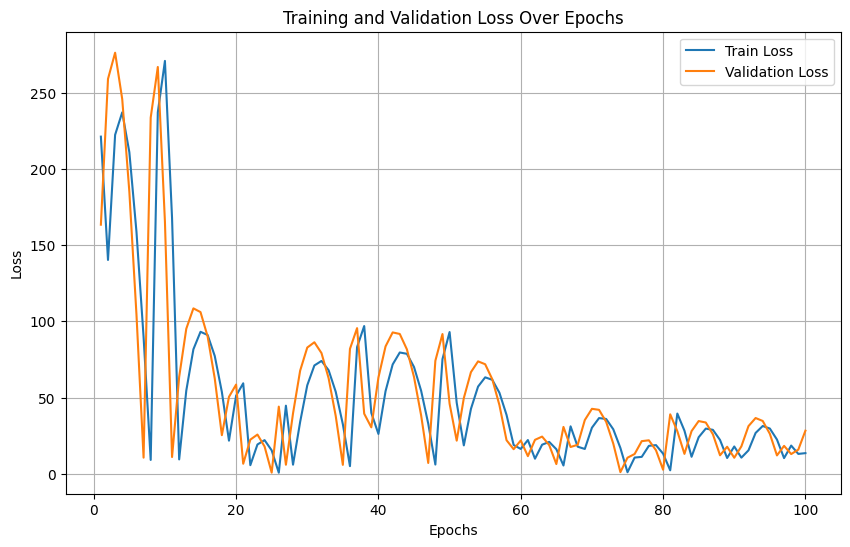

In [19]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.savefig("../03_plots/train_val_gnn100.png")  # Save as PNG
plt.show()